In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Input, Merge
from keras import backend as K
from keras.constraints import Constraint
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model

from keras.engine.topology import Layer

/home/jsk/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# PPITF and Supervised Train data
ppi = pd.read_csv('data/ppi_tf_merge_cluster.csv', sep='\t', header=None)
supervised_data_raw = pd.read_csv('data/supervised_train.txt', sep='\t')

data = np.load('supervised_train.npz')
x_train_raw, y_train = data['x_train'], data['y_train']
def binarize_data(x_train):
    x_train_new = np.copy(x_train)
    x_train_new[x_train_new != 0] = 1.0
    return x_train_new

x_train_bin = binarize_data(x_train_raw)

label_encoder = json.load(open('label_encoder.json', 'r'))
label_decoder = json.load(open('label_decoder.json', 'r'))
feature_encoder = json.load(open('feature_encoder.json', 'r'))
feature_decoder = json.load(open('feature_decoder.json', 'r'))
dim = len(feature_encoder.keys())

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

In [3]:
# startified train test split (withhold 3 class types)
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x_train_bin, y_train, test_size=0.33, random_state=42, stratify=y_train)

num_classes = np.unique(y_train).shape[0]
for i in range(num_classes):
    print("%d: %d"%(i, list(y_train).count(i)))

# split accroding to the class seen and unseen
unseen_classes = [3,7,12]
seen_idx = [i for i in range(len(y_train)) if y_train[i] not in unseen_classes]
unseen_idx = [i for i in range(len(y_train)) if y_train[i] in unseen_classes]

x_train_s = x_train_bin[seen_idx, :]
x_test_s = x_train_bin[unseen_idx, :]
y_train_s = y_train[seen_idx]
y_test_s = y_train[unseen_idx]

print('withheld: %s'%[label_decoder[str(i)] for i in unseen_classes])

0: 54
1: 14
2: 47
3: 18
4: 13
5: 8
6: 49
7: 22
8: 8
9: 43
10: 10
11: 10
12: 30
13: 12
14: 60
15: 4
withheld: [u'BMDC', u'PrE', u'lateblast']


## Pre-process PPITF File Information

In [4]:
# separate TF and PPI
names = list(ppi[0].as_matrix())
tf_idx = [i for i in range(len(names)) if 'TF:' in names[i]]
pp_idx = [i for i in range(len(names)) if 'TF:' not in names[i]]
tf_only = ppi.loc[tf_idx, :].as_matrix()
pp_only = ppi.loc[pp_idx, :].as_matrix()

In [5]:
# Convert the TF and PPI info to dictionary
tf_names = [n[4:] for n in names if 'TF:' in n]
tf_info = dict()
for i, n in enumerate(tf_names):
    tf_info[n] = [feature_encoder[d] for d in list(tf_only[i])[1:] if type(d) == str]
    
pp_info = dict()
for l in range(pp_only.shape[0]):
    pp_info[l] = [feature_encoder[d] for d in list(pp_only[l])[1:] if type(d) == str]
    
tf_nz_idx = []
for i in range(dim):
    for j in range(348):
        if i in tf_info[tf_info.keys()[j]]:
            tf_nz_idx.append((i,j))
            
pp_nz_idx = []
for i in range(dim):
    for j in range(348):
        if i in pp_info[j]:
            pp_nz_idx.append((i,j))

In [6]:
tf_mask = np.zeros((dim, 348))
pp_mask = np.zeros((dim, 348))
for (i, j) in tf_nz_idx:
    tf_mask[i,j] = 1.0
for (i, j) in pp_nz_idx:
    pp_mask[i,j] = 1.0

## Biologically Informed Supervised Method

In [7]:
# A NN where ther hidden layer will have (1) dense nodes, (2) TF nodes (3) PPI nodes

class GroupLayer(Layer):
    def __init__(self, output_dim, mask, **kwargs):
        self.output_dim = output_dim
        self.mask = mask
        super(GroupLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(GroupLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, self.kernel * self.mask)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def get_config(self):
        base_config = super(GroupLayer, self).get_config()
        base_config['output_dim'] = self.output_dim
        base_config['mask'] = self.mask
        return base_config
        

dense1 = Sequential()
dense1.add(Dense(units=50, input_dim=dim))

tf_nodes = Sequential()
tf_nodes.add(GroupLayer(348, tf_mask, input_shape=(dim, ), name='tfnode'))
pp_nodes = Sequential()
pp_nodes.add(GroupLayer(348, pp_mask, input_shape=(dim, ), name='ppnode'))

bio_model = Sequential()
bio_model.add(Merge([dense1, tf_nodes, pp_nodes], mode = 'concat'))
bio_model.add(Activation('tanh'))
bio_model.add(Dense(units=200, name='fc2'))
bio_model.add(Activation('tanh'))
bio_model.add(Dense(units=num_classes, name='output'))
bio_model.add(Activation('softmax'))
bio_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.99),
              metrics=['accuracy'])


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [8]:
one_hot_targets = np.eye(num_classes)[y_train_s]
bio_model.fit([x_train_s, x_train_s, x_train_s], one_hot_targets, epochs=100, batch_size=64)
bio_model.save('bio_nn.h5')

#bio_model = load_model('bio_nn.h5', custom_objects={'GroupLayer': GroupLayer})

Epoch 1/100
332/332 [==============================] - 0s 1ms/step - loss: 2.7500 - acc: 0.1386
Epoch 2/100
332/332 [==============================] - 0s 147us/step - loss: 2.3952 - acc: 0.1596
Epoch 3/100
332/332 [==============================] - 0s 149us/step - loss: 2.2370 - acc: 0.2470
Epoch 4/100
332/332 [==============================] - 0s 155us/step - loss: 2.0873 - acc: 0.3795
Epoch 5/100
332/332 [==============================] - 0s 163us/step - loss: 1.9866 - acc: 0.4669
Epoch 6/100
332/332 [==============================] - 0s 162us/step - loss: 1.8365 - acc: 0.5542
Epoch 7/100
332/332 [==============================] - 0s 165us/step - loss: 1.6882 - acc: 0.5000
Epoch 8/100
332/332 [==============================] - 0s 169us/step - loss: 1.5228 - acc: 0.5151
Epoch 9/100
332/332 [==============================] - 0s 165us/step - loss: 1.3609 - acc: 0.5904
Epoch 10/100
332/332 [==============================] - 0s 184us/step - loss: 1.2178 - acc: 0.7048
Epoch 11/100
332/332 

332/332 [==============================] - 0s 190us/step - loss: 0.0042 - acc: 1.0000
Epoch 84/100
332/332 [==============================] - 0s 154us/step - loss: 0.0040 - acc: 1.0000
Epoch 85/100
332/332 [==============================] - 0s 176us/step - loss: 0.0039 - acc: 1.0000
Epoch 86/100
332/332 [==============================] - 0s 187us/step - loss: 0.0038 - acc: 1.0000
Epoch 87/100
332/332 [==============================] - 0s 184us/step - loss: 0.0037 - acc: 1.0000
Epoch 88/100
332/332 [==============================] - 0s 185us/step - loss: 0.0036 - acc: 1.0000
Epoch 89/100
332/332 [==============================] - 0s 187us/step - loss: 0.0036 - acc: 1.0000
Epoch 90/100
332/332 [==============================] - 0s 185us/step - loss: 0.0035 - acc: 1.0000
Epoch 91/100
332/332 [==============================] - 0s 185us/step - loss: 0.0034 - acc: 1.0000
Epoch 92/100
332/332 [==============================] - 0s 183us/step - loss: 0.0034 - acc: 1.0000
Epoch 93/100
332/332 [=

In [9]:
bio_feature_model = Model(inputs=bio_model.input, outputs=bio_model.get_layer('fc2').output)
bio_features = bio_feature_model.predict([x_train_bin, x_train_bin, x_train_bin])

## Baseline Methods

In [10]:
## 2 layer FC NN
base_model = Sequential()
base_model.add(Dense(units=200, input_dim=x_train_s.shape[1], name='fc1'))
base_model.add(Activation('tanh'))
base_model.add(Dense(units=200, name='fc2'))
base_model.add(Activation('tanh'))
base_model.add(Dense(units=num_classes, name='output'))
base_model.add(Activation('softmax'))
base_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.99),
              metrics=['accuracy'])
#one hot encode y_train
one_hot_targets = np.eye(num_classes)[y_train_s]
base_model.fit(x_train_s, one_hot_targets, epochs=100, batch_size=64)
train_loss_acc = base_model.evaluate(x_train_s, one_hot_targets, batch_size=64)
print(train_loss_acc)
base_model.save('base_nn.h5')

#base_model = load_model('base_nn.h5')

layer_name = 'fc2'
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
baseline_features = feature_model.predict(x_train_bin)



Epoch 1/100
332/332 [==============================] - 0s 225us/step - loss: 2.5820 - acc: 0.1596
Epoch 2/100
332/332 [==============================] - 0s 55us/step - loss: 2.1797 - acc: 0.2229
Epoch 3/100
332/332 [==============================] - 0s 55us/step - loss: 1.9945 - acc: 0.4458
Epoch 4/100
332/332 [==============================] - 0s 59us/step - loss: 1.6534 - acc: 0.5452
Epoch 5/100
332/332 [==============================] - 0s 60us/step - loss: 1.3575 - acc: 0.6627
Epoch 6/100
332/332 [==============================] - 0s 60us/step - loss: 1.1645 - acc: 0.6476
Epoch 7/100
332/332 [==============================] - 0s 60us/step - loss: 0.9952 - acc: 0.7982
Epoch 8/100
332/332 [==============================] - 0s 60us/step - loss: 0.8418 - acc: 0.8253
Epoch 9/100
332/332 [==============================] - 0s 60us/step - loss: 0.7344 - acc: 0.8434
Epoch 10/100
332/332 [==============================] - 0s 65us/step - loss: 0.5945 - acc: 0.8855
Epoch 11/100
332/332 [======

332/332 [==============================] - 0s 56us/step - loss: 8.9126e-04 - acc: 1.0000
Epoch 85/100
332/332 [==============================] - 0s 56us/step - loss: 8.7173e-04 - acc: 1.0000
Epoch 86/100
332/332 [==============================] - 0s 55us/step - loss: 8.5516e-04 - acc: 1.0000
Epoch 87/100
332/332 [==============================] - 0s 60us/step - loss: 8.3913e-04 - acc: 1.0000
Epoch 88/100
332/332 [==============================] - 0s 61us/step - loss: 8.2357e-04 - acc: 1.0000
Epoch 89/100
332/332 [==============================] - 0s 61us/step - loss: 8.0860e-04 - acc: 1.0000
Epoch 90/100
332/332 [==============================] - 0s 59us/step - loss: 7.9520e-04 - acc: 1.0000
Epoch 91/100
332/332 [==============================] - 0s 59us/step - loss: 7.8296e-04 - acc: 1.0000
Epoch 92/100
332/332 [==============================] - 0s 60us/step - loss: 7.7111e-04 - acc: 1.0000
Epoch 93/100
332/332 [==============================] - 0s 61us/step - loss: 7.5934e-04 - acc: 

In [11]:
## PCA with 200 components
from sklearn.decomposition import PCA
pca200 = PCA(n_components=200)
pca200.fit(x_train_s)
pca200_features = pca200.transform(x_train_bin)

## Using gprofiler

In [39]:
# Then run the genes on gprofiler
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

In [72]:
# Specify the cell type interested in.
cell_type = 8
cell_type_str = label_decoder[str(cell_type)]
print(cell_type, cell_type_str)
top_k = 10

# First find important features to the cell type for baseline method
print('----BASELINE NN-----')
grad = K.gradients(base_model.output, base_model.input)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
grad_vals_base = sess.run(grad, feed_dict={base_model.input : x_train_s})[0]
cell_idx = np.where(y_train_s == cell_type)[0]
imp_order = np.flip(np.argsort(np.mean(grad_vals_base[cell_idx, :], axis=0)), axis=0)
print(imp_order[:top_k])
base_top_genes = [feature_decoder[str(x)] for x in imp_order[:top_k]]
print(base_top_genes)

print('---- BIONN -----')
grad_bio = K.gradients(bio_model.output, bio_model.input)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
grad_vals_bio = sess.run(grad_bio, feed_dict={bio_model.input[0] : x_train_s,
                                             bio_model.input[1] : x_train_s,
                                             bio_model.input[2] : x_train_s})[0]
cell_idx_bio = np.where(y_train_s == cell_type)[0]
imp_order_bio = np.flip(np.argsort(np.mean(grad_vals_bio[cell_idx_bio, :], axis=0)), axis=0)
print(imp_order_bio[:top_k])
bio_top_genes = [feature_decoder[str(x)] for x in imp_order_bio[:top_k]]
print(bio_top_genes)

print('------ grpofiler results -------')

gene_query_base = str(' '.join(base_top_genes[:3]))
gene_query_bio = str(' '.join(bio_top_genes[:3]))

result = gp.gprofile(gene_query_base, organism='mmusculus')
print('BaseNN', result)
if len(result) != 0:
    for r in result:
        print('p-val=%f\tontology=%s'%(r[2], r[11]))

result = gp.gprofile(gene_query_bio, organism='mmusculus')
print('BioNN', result)
if len(result) != 0:
    for r in result:
        print('p-val=%f\tontology=%s'%(r[2], r[11]))
        
print(gene_query_base, gene_query_bio)

(8, u'early2cell')
----BASELINE NN-----
[5731 3125  690 4917 2513  106 6329 2011 9422 2343]
[u'mos', u'fam179b', u'ercc6', u'creg1', u'bap1', u'ndrg2', u'bysl', u'pex16', u'dcbld1', u'ube2m']
---- BIONN -----
[8070 6812 4619 8493 4851 1033  341 9426 3249 3894]
[u'isl1', u'apod', u'got2', u'fam43a', u'osm', u'klf7', u'sec22a', u'armcx1', u'tbc1d14', u'bicd2']
------ grpofiler results -------
('BaseNN', [[1, True, 0.0499, 1, 1, 1, 1.0, 1.0, 'HP:0008125', 'hp', 1, 'Second metatarsal posteriorly placed', 1, 'ERCC6'], [1, True, 0.0499, 1, 1, 1, 1.0, 1.0, 'HP:0007346', 'hp', 1, 'Subcortical white matter calcifications', 1, 'ERCC6'], [1, True, 0.0499, 1, 1, 1, 1.0, 1.0, 'HP:0004681', 'hp', 1, 'Deep longitudinal plantar crease', 1, 'ERCC6'], [1, True, 0.0499, 1, 1, 1, 1.0, 1.0, 'HP:0007623', 'hp', 1, 'Pigmentation anomalies of sun-exposed skin', 1, 'ERCC6']])
p-val=0.049900	ontology=Second metatarsal posteriorly placed
p-val=0.049900	ontology=Subcortical white matter calcifications
p-val=0.049

## Semi-Supervised Method

In [12]:
# Load retrieval data
evalset = np.load('whole_eval_data.npz')
x_eval = evalset['x_eval']
y_eval = evalset['y_eval']

x_eval = binarize_data(x_eval)
del evalset

In [14]:
### Semi-supervised

# Autoencoder 
input_data = Input(shape=(dim,))

encoded = Dense(200, activation='tanh')(input_data)
encoded = Dense(200, activation='tanh')(encoded)

decoded = Dense(100, activation='tanh')(encoded)
decoded = Dense(200, activation='tanh')(decoded)
decoded = Dense(dim, activation='hard_sigmoid')(decoded)

autoencoder = Model(input_data, decoded)
opt = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999)
autoencoder.compile(optimizer='adam', loss='mse')

# autoencoder.fit(x_eval, x_eval,
#                 epochs=100,
#                 batch_size=256,
#                 shuffle=True)
# autoencoder.save('autoencoder.h5')

autoencoder = load_model('autoencoder.h5')

In [15]:
# Get the learned weights from the encoder
[w1, b1] = autoencoder.layers[1].get_weights()
[w2, b2] = autoencoder.layers[2].get_weights()

In [16]:
# Supervised Model Initialized with Autoencoder Weights
semi_model = Sequential()
semi_model.add(Dense(units=200, input_dim=dim, name='fc1'))
semi_model.add(Activation('tanh'))
semi_model.add(Dense(units=200, name='fc2'))
semi_model.add(Activation('tanh'))
semi_model.add(Dense(units=num_classes, name='output'))
semi_model.add(Activation('softmax'))
# initialize the weights
semi_model.layers[0].set_weights([w1, b1])
semi_model.layers[2].set_weights([w2, b2])
semi_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.99),
              metrics=['accuracy'])

In [17]:
one_hot_targets = np.eye(num_classes)[y_train_s]
semi_model.fit(x_train_s, one_hot_targets, epochs=200, batch_size=64)
semi_model.save('semi_nn.h5')

Epoch 1/200
332/332 [==============================] - 0s 331us/step - loss: 3.3162 - acc: 0.0211
Epoch 2/200
332/332 [==============================] - 0s 56us/step - loss: 2.6487 - acc: 0.1717
Epoch 3/200
332/332 [==============================] - 0s 56us/step - loss: 2.0642 - acc: 0.3765
Epoch 4/200
332/332 [==============================] - 0s 56us/step - loss: 1.8700 - acc: 0.4880
Epoch 5/200
332/332 [==============================] - 0s 56us/step - loss: 1.7930 - acc: 0.4880
Epoch 6/200
332/332 [==============================] - 0s 55us/step - loss: 1.6076 - acc: 0.5361
Epoch 7/200
332/332 [==============================] - 0s 59us/step - loss: 1.3703 - acc: 0.5602
Epoch 8/200
332/332 [==============================] - 0s 56us/step - loss: 1.2006 - acc: 0.5964
Epoch 9/200
332/332 [==============================] - 0s 56us/step - loss: 1.0972 - acc: 0.6235
Epoch 10/200
332/332 [==============================] - 0s 55us/step - loss: 1.0152 - acc: 0.6747
Epoch 11/200
332/332 [======

332/332 [==============================] - 0s 82us/step - loss: 0.0245 - acc: 1.0000
Epoch 85/200
332/332 [==============================] - 0s 83us/step - loss: 0.0234 - acc: 1.0000
Epoch 86/200
332/332 [==============================] - 0s 81us/step - loss: 0.0224 - acc: 1.0000
Epoch 87/200
332/332 [==============================] - 0s 82us/step - loss: 0.0214 - acc: 1.0000
Epoch 88/200
332/332 [==============================] - 0s 83us/step - loss: 0.0205 - acc: 1.0000
Epoch 89/200
332/332 [==============================] - 0s 83us/step - loss: 0.0197 - acc: 1.0000
Epoch 90/200
332/332 [==============================] - 0s 82us/step - loss: 0.0190 - acc: 1.0000
Epoch 91/200
332/332 [==============================] - 0s 83us/step - loss: 0.0184 - acc: 1.0000
Epoch 92/200
332/332 [==============================] - 0s 80us/step - loss: 0.0180 - acc: 1.0000
Epoch 93/200
332/332 [==============================] - 0s 80us/step - loss: 0.0175 - acc: 1.0000
Epoch 94/200
332/332 [===========

332/332 [==============================] - 0s 76us/step - loss: 0.0046 - acc: 1.0000
Epoch 168/200
332/332 [==============================] - 0s 79us/step - loss: 0.0046 - acc: 1.0000
Epoch 169/200
332/332 [==============================] - 0s 79us/step - loss: 0.0045 - acc: 1.0000
Epoch 170/200
332/332 [==============================] - 0s 76us/step - loss: 0.0045 - acc: 1.0000
Epoch 171/200
332/332 [==============================] - 0s 81us/step - loss: 0.0045 - acc: 1.0000
Epoch 172/200
332/332 [==============================] - 0s 79us/step - loss: 0.0044 - acc: 1.0000
Epoch 173/200
332/332 [==============================] - 0s 77us/step - loss: 0.0044 - acc: 1.0000
Epoch 174/200
332/332 [==============================] - 0s 78us/step - loss: 0.0043 - acc: 1.0000
Epoch 175/200
332/332 [==============================] - 0s 78us/step - loss: 0.0043 - acc: 1.0000
Epoch 176/200
332/332 [==============================] - 0s 81us/step - loss: 0.0043 - acc: 1.0000
Epoch 177/200
332/332 [=

In [18]:
semi_feature_model = Model(inputs=semi_model.input, outputs=semi_model.get_layer('fc2').output)
semi_features = semi_feature_model.predict(x_train_bin)

## Clustering and ARI

In [19]:
# TSNE visualization
from sklearn.manifold import TSNE
model_names = ['semi-nn', 'bio-nn', 'pca', 'base-nn']
feature_outs = [semi_features, bio_features, pca200_features, baseline_features]
fig_idx = [(0,0), (0,1), (1,0), (1,1)]

tsne_outputs = []
for m, f in zip(model_names, feature_outs):
    X_embedded = TSNE(n_components=2).fit_transform(f)
    tsne_outputs.append(X_embedded)



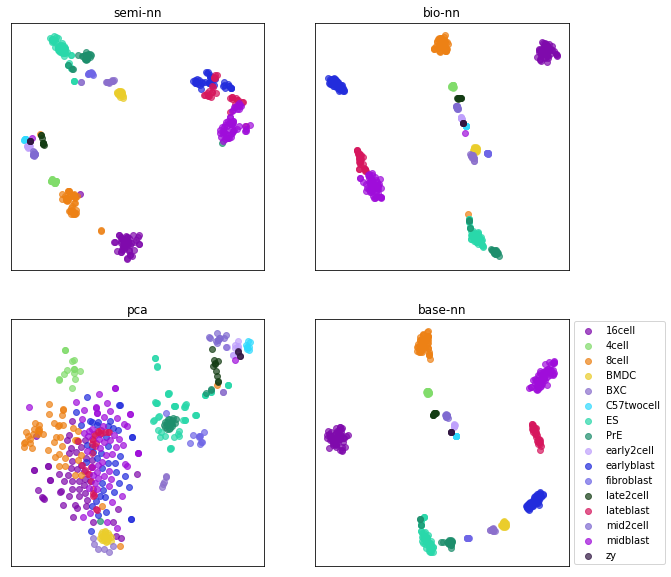

In [20]:
# Plt TSNE results
colors = []
for i in range(len(np.unique(y_train))):
    np.random.seed(i*71)
    colors.append('#%06X' %np.random.randint(0, 0xFFFFFF))

f, axs = plt.subplots(2,2, figsize=(10, 10))
count = 0
for m, f, X in zip(model_names, feature_outs, tsne_outputs):
    ax = axs[fig_idx[count][0], fig_idx[count][1]]
    for l, c in zip(np.unique(y_train), colors):
        ax.scatter(X[y_train == l, 0], X[y_train == l, 1], c=c, label=label_decoder[str(l)], alpha=0.7)
    ax.set_title(m)
    ax.set_xticks(())
    ax.set_yticks(())
    count += 1
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

In [21]:
# Kmens cluster and compute ARI & Ami
from sklearn import metrics
from sklearn.cluster import KMeans

ari_results = []
ami_results = []
for m, f in zip(model_names, feature_outs):
    # cluster just the unseen ones
    X = f[unseen_idx, :]
    labels_true = y_train[unseen_idx]
    kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
    cluster_centers_ = kmeans.cluster_centers_
    labels = kmeans.labels_
    ari = metrics.adjusted_rand_score(labels_true, labels)
    ami = metrics.adjusted_mutual_info_score(labels_true, labels)
    ari_results.append(ari)
    ami_results.append(ami)

for m, val1, val2 in zip(model_names, ari_results, ami_results):
    print('%s & %0.3f & %0.3f \\\ \\hline'%(m, val1, val2))

semi-nn & 1.000 & 1.000 \\ \hline
bio-nn & 1.000 & 1.000 \\ \hline
pca & 0.876 & 0.846 \\ \hline
base-nn & 1.000 & 1.000 \\ \hline


In [23]:
# Repeat multiple splitting settings
trials = []
for i in range(10):
    unseen_classes = list(np.random.choice(range(16), 3, replace=False))
    print('trial %d: unseen %s'%(i, unseen_classes))
    seen_idx = [i for i in range(len(y_train)) if y_train[i] not in unseen_classes]
    unseen_idx = [i for i in range(len(y_train)) if y_train[i] in unseen_classes]

    x_train_s = x_train_bin[seen_idx, :]
    x_test_s = x_train_bin[unseen_idx, :]
    y_train_s = y_train[seen_idx]
    y_test_s = y_train[unseen_idx]

    one_hot_targets = np.eye(num_classes)[y_train_s]
    bio_model.fit([x_train_s, x_train_s, x_train_s], one_hot_targets, epochs=100, batch_size=64, verbose=0)
    base_model.fit(x_train_s, one_hot_targets, epochs=100, batch_size=64, verbose=0)
    # Get the learned weights from the encoder
    [w1, b1] = autoencoder.layers[1].get_weights()
    [w2, b2] = autoencoder.layers[2].get_weights()
    semi_model.layers[0].set_weights([w1, b1])
    semi_model.layers[2].set_weights([w2, b2])
    semi_model.fit(x_train_s, one_hot_targets, epochs=100, batch_size=64, verbose=0)
    
    feature_model = Model(inputs=semi_model.input, outputs=semi_model.get_layer('fc2').output)
    semi_features = feature_model.predict(x_train_bin)
    
    feature_model = Model(inputs=bio_model.input, outputs=bio_model.get_layer('fc2').output)
    bio_features = feature_model.predict([x_train_bin, x_train_bin, x_train_bin])
    
    feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
    base_features = feature_model.predict(x_train_bin)
    
    pca200.fit(x_train_s)
    pca200_features = pca200.transform(x_train_bin)
    
    feature_outs = [semi_features, bio_features, pca200_features, base_features]
    ari_results = []
    ami_results = []
    for m, f in zip(model_names, feature_outs):
        # cluster just the unseen ones
        X = f[unseen_idx, :]
        labels_true = y_train[unseen_idx]
        kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
        cluster_centers_ = kmeans.cluster_centers_
        labels = kmeans.labels_
        ari = metrics.adjusted_rand_score(labels_true, labels)
        ami = metrics.adjusted_mutual_info_score(labels_true, labels)
        ari_results.append(ari)
        ami_results.append(ami)
    trials.append((ari_results, ami_results))

print('done computing for each trials.')

for i, m in enumerate(model_names):
    ari_avg = np.mean([trials[j][0][i] for j in range(10)])
    ami_avg = np.mean([trials[j][1][i] for j in range(10)])
    print('%s & %0.3f & %0.3f \\\ \\hline'%(m, ari_avg, ami_avg))

trial 0: unseen [6, 9, 11]
trial 1: unseen [4, 7, 13]
trial 2: unseen [12, 2, 8]
trial 3: unseen [11, 6, 12]
trial 4: unseen [5, 8, 4]
trial 5: unseen [15, 2, 1]
trial 6: unseen [13, 8, 0]
trial 7: unseen [6, 4, 15]
trial 8: unseen [6, 2, 11]
trial 9: unseen [5, 13, 9]
done computing for each trials.
semi-nn & 0.770 & 0.736 \\ \hline
bio-nn & 0.998 & 0.995 \\ \hline
pca & 0.647 & 0.649 \\ \hline
base-nn & 0.998 & 0.995 \\ \hline
